In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import cv2
import glob
import numpy as np
import scipy.io as sio
from scipy.stats import skew
from scipy.stats import kurtosis
import pywt
from skimage.feature import greycomatrix
import scipy.io as sio
import numpy as np
import seaborn as sn
import pandas as pd
from sklearn import preprocessing
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import to_categorical
from sklearn import metrics
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from sklearn.decomposition import KernelPCA
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import itertools
import os
from sklearn.metrics import roc_curve, auc
kl = keras.layers
# =============================================================================
# im2double
# =============================================================================
def im2double(img):
    """ convert image to double format """
    min_val = np.min(img.ravel())
    max_val = np.max(img.ravel())
    out = (img.astype('float') - min_val) / (max_val - min_val)
    return out
# =============================================================================
# compute_14_features
# =============================================================================
def compute_14_features(region):
    """ Compute 14 features """
    temp_array=region.reshape(-1)
    all_pixels=temp_array[temp_array!=0]
#    Area
    Area = np.sum(all_pixels)
#    mean
    density = np.mean(all_pixels)
#   Std
    std_Density = np.std(all_pixels)
#   skewness
    Skewness = skew(all_pixels)
#   kurtosis
    Kurtosis = kurtosis(all_pixels)
#   Energy
    ENERGY =np.sum(np.square(all_pixels))
#   Entropy
    value,counts = np.unique(all_pixels, return_counts=True)
    p = counts / np.sum(counts)
    p =  p[p!=0]
    ENTROPY =-np.sum( p*np.log2(p));
#   Maximum
    MAX = np.max(all_pixels)
#   Mean Absolute Deviation
    sum_deviation= np.sum(np.abs(all_pixels-np.mean(all_pixels)))
    mean_absolute_deviation = sum_deviation/len(all_pixels)
#   Median
    MEDIAN = np.median(all_pixels)
#   Minimum
    MIN = np.min(all_pixels)
#   Range
    RANGE = np.max(all_pixels)-np.min(all_pixels)
#   Root Mean Square
    RMS = np.sqrt(np.mean(np.square(all_pixels))) 
#    Uniformity
    UNIFORMITY = np.sum(np.square(p))

    features = np.array([Area, density, std_Density,
        Skewness, Kurtosis,ENERGY, ENTROPY,
        MAX, mean_absolute_deviation, MEDIAN, MIN, RANGE, RMS, UNIFORMITY])
    return features
# =============================================================================
# GLDM
# =============================================================================
def GLDM(img, distance):
    """ GLDM in four directions """
    pro1=np.zeros(img.shape,dtype=np.float32)
    pro2=np.zeros(img.shape,dtype=np.float32)
    pro3=np.zeros(img.shape,dtype=np.float32)
    pro4=np.zeros(img.shape,dtype=np.float32)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):

            if((j+distance)<img.shape[1]):
                pro1[i,j]=np.abs(img[i,j]-img[i,(j+distance)])
            if((i-distance)>0)&((j+distance)<img.shape[1]):
                pro2[i,j]=np.abs(img[i,j]-img[(i-distance),(j+distance)])
            if((i+distance)<img.shape[0]):
                pro3[i,j]=np.abs(img[i,j]-img[(i+distance),j])
            if((i-distance)>0)&((j-distance)>0):
                pro4[i,j]=np.abs(img[i,j]-img[(i-distance),(j-distance)])

    n=256;
    cnt, bin_edges=np.histogram(pro1[pro1!=0], bins=np.arange(n)/(n-1), density=False)
    Out1 = cnt.cumsum()
    cnt, bin_edges=np.histogram(pro2[pro2!=0], bins=np.arange(n)/(n-1), density=False)
    Out2 = cnt.cumsum()
    cnt, bin_edges=np.histogram(pro3[pro3!=0], bins=np.arange(n)/(n-1), density=False)
    Out3 = cnt.cumsum()
    cnt, bin_edges=np.histogram(pro4[pro4!=0], bins=np.arange(n)/(n-1), density=False)
    Out4 = cnt.cumsum()
    return Out1,Out2,Out3,Out4
# =============================================================================
#   show model
# =============================================================================
def show_model(model):
    plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
    return Image(filename='model.png')
# =============================================================================
# build model
# =============================================================================
def build_model(feature_size, n_classes):
    """ Build a small model for multi-label classification """
    inp = kl.Input((feature_size,))
    x = kl.Dense(128, activation='sigmoid')(inp)
    x=kl.Dropout(0.2)(x)
    x = kl.Dense(16, activation='sigmoid')(x)
    x=kl.Dropout(0.2)(x)
    out = kl.Dense(n_classes, activation='sigmoid')(x)
    model = keras.Model(inputs=inp, outputs=out)
    model.summary()
    return model
# =============================================================================
# plot confusion matrix
# =============================================================================
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# =============================================================================
# feature extraction to create feature pool
# =============================================================================
import skimage.io as io
from skimage.transform import  rescale,resize
from skimage.util import img_as_uint,img_as_ubyte
from skimage.color import rgb2gray
from skimage import exposure
from sklearn.preprocessing import MinMaxScaler
import os
import numpy as np
from numpy import*
# =============================================================================
# source dir and output file name
# =============================================================================
files_list = ["normal", "pneumonia", "covid19"]
for folders in files_list:
  class_name=folders#'covid' or 'normal' or 'pneumonia'
  source_dir='../content/drive/My Drive/Databases/MaskDetection-PreProcessed/'
  output_file_name=class_name
  # =============================================================================
  # set labels
  # =============================================================================
  if output_file_name=='covid19':
      label=0
  elif output_file_name=='normal':
     label=1
  else:
      label=2
  # =============================================================================
  # start
  # =============================================================================
  image_list=os.listdir(source_dir)#list of images

  feature_pool=np.empty([1,252])#feature pool
  for idx,img_name in enumerate(image_list):
      print(idx)
      img=cv2.imread(os.path.join(source_dir,img_name))
      img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      img_rescaled=(img-np.min(img))/(np.max(img)-np.min(img)) 
    
      texture_features=compute_14_features(img_rescaled)#texture features
    
      fft_map=np.fft.fft2(img_rescaled)
      fft_map = np.fft.fftshift(fft_map)
      fft_map = np.abs(fft_map)
      YC=int(np.floor(fft_map.shape[1]/2)+1)
      fft_map=fft_map[:,YC:int(np.floor(3*YC/2))]
      fft_features=compute_14_features(fft_map)#FFT features
    
      wavelet_coeffs = pywt.dwt2(img_rescaled,'sym4')
      cA1, (cH1, cV1, cD1) = wavelet_coeffs
      wavelet_coeffs = pywt.dwt2(cA1,'sym4')
      cA2, (cH2, cV2, cD2) = wavelet_coeffs#wavelet features
      wavelet_features=np.concatenate((compute_14_features(cA1), compute_14_features(cH1),compute_14_features(cV1),compute_14_features(cD1)
      ,compute_14_features(cA2), compute_14_features(cH2),compute_14_features(cV2),compute_14_features(cD2)), axis=0)
    
    
      gLDM1,gLDM2,gLDM3,gLDM4=GLDM(img_rescaled,10)#GLDM in four directions
      gldm_features=np.concatenate((compute_14_features(gLDM1), compute_14_features(gLDM2),
                                    compute_14_features(gLDM3),compute_14_features(gLDM4)), axis=0)
    
    
      glcms =greycomatrix(img, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])#GLCM in four directions
      glcm_features=np.concatenate((compute_14_features(im2double(glcms[:, :, 0, 0])), 
                                    compute_14_features(im2double(glcms[:, :, 0, 1])),
                                    compute_14_features(im2double(im2double(glcms[:, :, 0, 2]))),
                                    compute_14_features(glcms[:, :, 0, 3])), axis=0)
    
      feature_vector=np.concatenate((texture_features,fft_features,wavelet_features,gldm_features,glcm_features), axis=0).reshape(1,252)#merge to create a feature vector of 252
      feature_pool=np.concatenate((feature_pool,feature_vector), axis=0)


  feature_pool=np.delete(feature_pool, 0, 0)
  feature_pool=np.concatenate((feature_pool,label*np.ones(len(feature_pool)).reshape(len(feature_pool),1)), axis=1)#add label to the last column   
  print("Saving file "+output_file_name+'.mat...' )
  sio.savemat("../content/drive/My Drive/Databases/Covid19-PreProcessed/"+output_file_name+'.mat', {output_file_name: feature_pool})#save the created feature pool as a mat file

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
# =============================================================================
# evaluate extracted features on mat files
# =============================================================================
import scipy.io as sio
import os
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc , classification_report
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# =============================================================================
# source dir
# =============================================================================
source_dir='../content/drive/My Drive/Databases/Covid19-PreProcessed/'
# =============================================================================
# load mat files
# =============================================================================
covid_features=sio.loadmat(os.path.join(source_dir,'covid19.mat')) 
normal_features=sio.loadmat(os.path.join(source_dir,'normal.mat')) 
pneumonia_features=sio.loadmat(os.path.join(source_dir,'pneumonia.mat'))
print(covid_features.keys())
print(normal_features.keys())
print(pneumonia_features.keys())

dict_keys(['__header__', '__version__', '__globals__', 'covid19'])
dict_keys(['__header__', '__version__', '__globals__', 'normal'])
dict_keys(['__header__', '__version__', '__globals__', 'pneumonia'])


In [ ]:


covid_features=covid_features['covid19'] 
normal_features=normal_features['normal']   
pneumonia_features=pneumonia_features['pneumonia']  

print("\nCovid-19 Features")
print(covid_features)
print("\nNormal")
print(normal_features)
print("\nPneumonia")
print(pneumonia_features)


Covid-19 Features
[[1.27581604e+05 4.86696335e-01 2.49311279e-01 ... 8.42122257e+01
  9.44847381e-02 0.00000000e+00]
 [1.00292600e+05 3.82591745e-01 2.41244270e-01 ... 1.01395351e+02
  1.14928334e-01 0.00000000e+00]
 [1.25128792e+05 4.77333924e-01 2.32200087e-01 ... 2.95674558e+01
  9.57825219e-02 0.00000000e+00]
 ...
 [1.53038961e+05 5.83808441e-01 2.12786786e-01 ... 2.86143550e+01
  8.81556871e-02 0.00000000e+00]
 [1.66858325e+05 6.36535852e-01 2.63818729e-01 ... 5.35472776e+01
  1.08173917e-01 0.00000000e+00]
 [1.44363000e+05 5.50724251e-01 2.29871050e-01 ... 6.97603900e+01
  9.83639607e-02 0.00000000e+00]]

Normal
[[1.13755094e+05 4.35703046e-01 2.47367922e-01 ... 1.98749125e+02
  1.07571862e-01 1.00000000e+00]
 [1.18734545e+05 4.53781091e-01 2.57857370e-01 ... 1.96035998e+02
  9.91601860e-02 1.00000000e+00]
 [1.24955949e+05 4.80714436e-01 2.47094206e-01 ... 1.35262340e+02
  9.94465206e-02 1.00000000e+00]
 ...
 [1.14980384e+05 4.38622050e-01 2.72295865e-01 ... 2.17137356e+02
  9.9

In [ ]:
# =============================================================================
# mat to csv
# =============================================================================
covid_features_csv = pd.DataFrame(covid_features)
covid_features_csv.to_csv("../content/drive/My Drive/Databases/Covid19-PreProcessed/covid_features.csv")

normal_features_csv = pd.DataFrame(normal_features)
normal_features_csv.to_csv("../content/drive/My Drive/Databases/Covid19-PreProcessed/normal_features.csv")

pneumonia_features_csv = pd.DataFrame(pneumonia_features)
pneumonia_features_csv.to_csv("../content/drive/My Drive/Databases/Covid19-PreProcessed/pneumonia_features.csv")

In [ ]:
scores=np.concatenate((covid_features[:,:-1],normal_features[:,:-1],pneumonia_features[:,:-1]), axis=0)
targets=np.concatenate((covid_features[:,-1],normal_features[:,-1],pneumonia_features[:,-1]), axis=0)
print("\nScores\n"+ str(scores))
print("\nTargets\n"+ str(targets))


Scores
[[1.27581604e+05 4.86696335e-01 2.49311279e-01 ... 7.83400000e+03
  8.42122257e+01 9.44847381e-02]
 [1.00292600e+05 3.82591745e-01 2.41244270e-01 ... 8.72900000e+03
  1.01395351e+02 1.14928334e-01]
 [1.25128792e+05 4.77333924e-01 2.32200087e-01 ... 1.89900000e+03
  2.95674558e+01 9.57825219e-02]
 ...
 [1.51746686e+05 5.78922880e-01 2.31860661e-01 ... 5.48000000e+02
  3.52176448e+01 1.31324217e-01]
 [1.23235165e+05 5.28822310e-01 2.15214971e-01 ... 2.79470000e+04
  2.19513703e+02 8.99844799e-02]
 [1.53937812e+05 5.87232870e-01 2.25250386e-01 ... 2.51000000e+02
  3.47417505e+01 8.21728453e-02]]

Targets
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.

In [ ]:
# =============================================================================
# Normalization
# =============================================================================
min_max_scaler=MinMaxScaler()
scores = min_max_scaler.fit_transform(scores) 
print("Scores\n"+str(scores))

Scores
[[0.50521934 0.50517557 0.52013822 ... 0.09486244 0.08166313 0.32768836]
 [0.26043884 0.26041296 0.47271923 ... 0.1059289  0.10476455 0.49701462]
 [0.48321779 0.4831634  0.41955627 ... 0.02147759 0.00819734 0.3384374 ]
 ...
 [0.72197848 0.72201145 0.41756107 ... 0.0047728  0.01579359 0.63281527]
 [0.46623208 0.60421889 0.3197154  ... 0.34355487 0.26356581 0.2904145 ]
 [0.74163272 0.74154925 0.37870496 ... 0.00110046 0.01515379 0.2257138 ]]


In [ ]:
df = pd.DataFrame(scores)       
df.head()

0         1         2         3    ...  248       249       250       251
0  0.505219  0.505176  0.520138  0.535071  ...  0.0  0.094862  0.081663  0.327688
1  0.260439  0.260413  0.472719  0.706859  ...  0.0  0.105929  0.104765  0.497015
2  0.483218  0.483163  0.419556  0.680960  ...  0.0  0.021478  0.008197  0.338437
3  0.792655  0.792566  0.125918  0.355066  ...  0.0  0.006764  0.048064  0.219762
4  0.631101  0.631480  0.371839  0.303612  ...  0.0  0.018003  0.033213  0.362114

[5 rows x 252 columns]

          0         1         2         3    ...  248       249       250       251
0    1.000000  0.973567  0.393915  0.750839  ...  0.0  0.679123  0.649030  0.031818
1    0.973567  1.000000  0.436741  0.757093  ...  0.0  0.631001  0.609140  0.036858
2    0.393915  0.436741  1.000000  0.337598  ...  0.0  0.678069  0.620040  0.016419
3    0.750839  0.757093  0.337598  1.000000  ...  0.0  0.342347  0.296972  0.092149
4    0.664546  0.677486  0.711785  0.750129  ...  0.0  0.538426  0.509639  0.025712
..        ...       ...       ...       ...  ...  ...       ...       ...       ...
247  0.074059  0.080692  0.064498  0.012167  ...  0.0  0.042436  0.054905  0.854866
248  0.000000  0.000000  0.000000  0.000000  ...  0.0  0.000000  0.000000  0.000000
249  0.679123  0.631001  0.678069  0.342347  ...  0.0  1.000000  0.963511  0.005841
250  0.649030  0.609140  0.620040  0.296972  ...  0.0  0.963511  1.000000  0.069696
251  0.031818  0.036858  0.016419  0.092149  ...  0.0  0.005841  0.069696  1

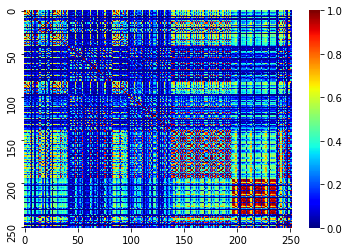

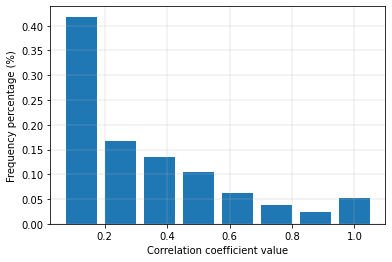

In [ ]:
corrMatrix = df.corr().abs().fillna(0)
print(corrMatrix)
# =============================================================================
# correlation map and histogram 
# =============================================================================
fig = plt.figure()
sn.heatmap(corrMatrix,xticklabels=50,yticklabels=50,cmap='jet')
plt.savefig('corr_map',dpi=300,format='eps')

# 
fig = plt.figure()
(h,x)=np.histogram(corrMatrix.to_numpy().reshape(1,252*252), bins=8) 
plt.bar(x[1:],h/(252*252),width=0.1)            
plt.grid(linewidth=.3)  
plt.xlabel('Correlation coefficient value')
plt.ylabel('Frequency percentage (%)')
plt.savefig('corr_hist.jpg',dpi=6000)

164
0.8389220779220778


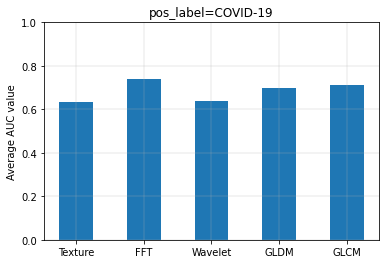

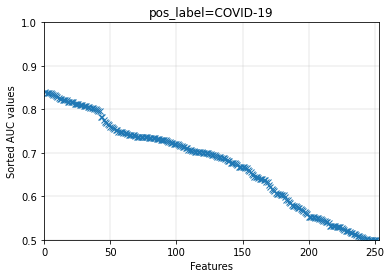

In [ ]:
# =============================================================================
# auc value graphs where positive label is COVID-19             
# =============================================================================
pos_label=0   
roc_list=[]  

for idx in range(scores.shape[1]):               
    fpr, tpr, thresholds = roc_curve(targets, scores[:,idx], pos_label=pos_label)
    auc_value=auc(fpr, tpr)
    if auc_value<0.5:
        auc_value=1-auc_value
    roc_list.append(auc_value)# calculate auc value

print(np.argmax(roc_list))
print(np.max(roc_list))
fig = plt.figure()
plt.bar([1,2,3,4,5],[np.mean(roc_list[:14]),np.mean(roc_list[14:28])
        ,np.mean(roc_list[28:140]),np.mean(roc_list[140:196]),np.mean(roc_list[196:252])]
        ,width=0.5)

plt.xticks([1,2,3,4,5], ('Texture', 'FFT', 'Wavelet', 'GLDM', 'GLCM'))
plt.grid(linewidth=.3)
plt.ylim([0, 1])
plt.title('pos_label=COVID-19')
plt.ylabel('Average AUC value')
plt.savefig('avg_bar_pos_COVID.jpg',dpi=300)

fig = plt.figure()
plt.plot([i for i in range(1,scores.shape[1]+1)],np.sort(roc_list)[::-1],'x')
plt.grid(linewidth=.3)
plt.xlim([0.0, scores.shape[1]+1])
plt.ylim([0.5, 1])
plt.xlabel('Features')
plt.ylabel('Sorted AUC values')
plt.title('pos_label=COVID-19')
plt.savefig('auc_pos_COVID.jpg',dpi=300)

In [ ]:
print(np.mean(roc_list[:14]))
print(np.mean(roc_list[14:28]))
print(np.mean(roc_list[28:140]))
print(np.mean(roc_list[140:196]))
print(np.mean(roc_list[196:252]))

0.6347374768089055
0.7394248608534324
0.6385435992578851
0.6990173933209647
0.7134459647495363


172
0.917992293251655


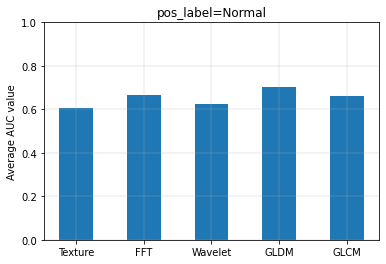

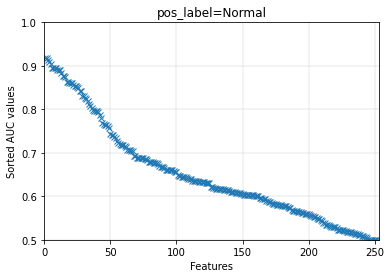

In [ ]:
# =============================================================================
# auc value graphs where positive label is normal
# =============================================================================
pos_label=1   
roc_list=[]  
for idx in range(scores.shape[1]):               
    fpr, tpr, thresholds = roc_curve(targets, scores[:,idx], pos_label=pos_label)
    auc_value=auc(fpr, tpr)
    if auc_value<0.5:
        auc_value=1-auc_value
    roc_list.append(auc_value)# calculate auc value

fig = plt.figure()
plt.bar([1,2,3,4,5],[np.mean(roc_list[:14]),np.mean(roc_list[14:28])
        ,np.mean(roc_list[28:140]),np.mean(roc_list[140:196]),np.mean(roc_list[196:252])]
        ,width=0.5)

plt.xticks([1,2,3,4,5], ('Texture', 'FFT', 'Wavelet', 'GLDM', 'GLCM'))
plt.grid(linewidth=.3)
plt.ylim([0, 1])
plt.title('pos_label=Normal')
plt.ylabel('Average AUC value')
plt.savefig('avg_bar_pos_Normal.jpg',dpi=300)

print(np.argmax(roc_list))
print(np.max(roc_list))
fig = plt.figure()
plt.plot([i for i in range(1,scores.shape[1]+1)],np.sort(roc_list)[::-1],'x')
plt.grid(linewidth=.3)
plt.xlim([0.0, scores.shape[1]+1])
plt.ylim([0.5, 1])
plt.xlabel('Features')
plt.ylabel('Sorted AUC values')
plt.title('pos_label=Normal')
plt.savefig('auc_pos_Normal.jpg',dpi=300)

In [ ]:
print(np.mean(roc_list[:14]))
print(np.mean(roc_list[14:28]))
print(np.mean(roc_list[28:140]))
print(np.mean(roc_list[140:196]))
print(np.mean(roc_list[196:252]))

0.6070291815965592
0.6661215617558157
0.6248936654742917
0.7026501021315552
0.6598754559624462


176
0.8587698513441088


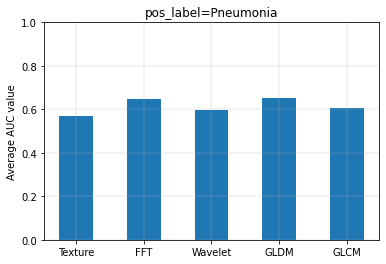

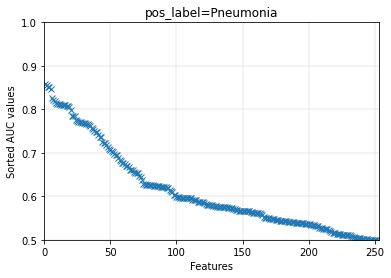

In [ ]:
# =============================================================================
# auc value graphs where positive label is pneumonia
# =============================================================================
pos_label=2   
roc_list=[]  
for idx in range(scores.shape[1]):               
    fpr, tpr, thresholds = roc_curve(targets, scores[:,idx], pos_label=pos_label)
    auc_value=auc(fpr, tpr)
    if auc_value<0.5:
        auc_value=1-auc_value
    roc_list.append(auc_value)# calculate auc value

print(np.argmax(roc_list))
print(np.max(roc_list))

fig = plt.figure()
plt.bar([1,2,3,4,5],[np.mean(roc_list[:14]),np.mean(roc_list[14:28])
        ,np.mean(roc_list[28:140]),np.mean(roc_list[140:196]),np.mean(roc_list[196:252])]
        ,width=0.5)

plt.xticks([1,2,3,4,5], ('Texture', 'FFT', 'Wavelet', 'GLDM', 'GLCM'))
plt.grid(linewidth=.3)
plt.ylim([0, 1])
plt.title('pos_label=Pneumonia')
plt.ylabel('Average AUC value')
plt.savefig('avg_bar_pos_Pneumonia.jpg',dpi=300)

fig = plt.figure()
plt.plot([i for i in range(1,scores.shape[1]+1)],np.sort(roc_list)[::-1],'x')
plt.grid(linewidth=.3)
plt.xlim([0.0, scores.shape[1]+1])
plt.ylim([0.5, 1])
plt.xlabel('Features')
plt.ylabel('Sorted AUC values')
plt.title('pos_label=Pneumonia')
plt.savefig('auc_pos_Pneumonia.jpg',dpi=300)

In [ ]:
print(np.mean(roc_list[:14]))
print(np.mean(roc_list[14:28]))
print(np.mean(roc_list[28:140]))
print(np.mean(roc_list[140:196]))
print(np.mean(roc_list[196:252]))

0.5713882743585713
0.6473361621876472
0.5987489459797628
0.6521107983051052
0.6046856803354329


In [ ]:
import pandas as pd
df_pneumonia = pd.read_csv("../content/drive/My Drive/Databases/Covid19-PreProcessed/pneumonia_features.csv")
df_covid = pd.read_csv("../content/drive/My Drive/Databases/Covid19-PreProcessed/covid_features.csv")
df_normal = pd.read_csv("../content/drive/My Drive/Databases/Covid19-PreProcessed/normal_features.csv")
df_pneumonia = df_pneumonia.iloc[:, 1:15]
df_covid = df_covid.iloc[:, 1:15]
df_normal = df_normal.iloc[:, 1:15]
columns_list = ['Area', 'Density', 'Std_Density',
        'Skewness', 'Kurtosis','ENERGY', 'ENTROPY',
        'MAX', 'Mean_Absolute_Deviation', 'MEDIAN', 'MIN', 'RANGE', 'RMS', 'UNIFORMITY']
df_pneumonia.columns = columns_list
df_covid.columns = columns_list
df_normal.columns = columns_list
df_normal.head()
df_pneumonia.head()
df_covid.head()

Area   Density  Std_Density  ...     RANGE       RMS  UNIFORMITY
0  127581.603922  0.486696     0.249311  ...  0.996078  0.546836    0.006355
1  100292.600000  0.382592     0.241244  ...  0.996078  0.452300    0.008272
2  125128.792157  0.477334     0.232200  ...  0.996078  0.530815    0.004684
3  159625.976471  0.608932     0.182246  ...  0.996078  0.635619    0.007001
4  141615.301961  0.540417     0.224082  ...  0.996078  0.585033    0.006754

[5 rows x 14 columns]

In [ ]:
sum_normal = df_normal.sum(axis=0)
sum_normal

Area                       4.474454e+07
Density                    1.718051e+02
Std_Density                8.849376e+01
Skewness                  -1.169766e+02
Kurtosis                  -2.946242e+02
ENERGY                     2.803993e+07
ENTROPY                    2.639629e+03
MAX                        3.490000e+02
Mean_Absolute_Deviation    7.434890e+01
MEDIAN                     1.830784e+02
MIN                        1.368627e+00
RANGE                      3.476314e+02
RMS                        1.935580e+02
UNIFORMITY                 3.986533e+00
dtype: float64

In [ ]:
sum_covid = df_covid.sum(axis=0)
sum_covid

Area                       7.860457e+06
Density                    2.999087e+01
Std_Density                1.263345e+01
Skewness                  -2.807733e+01
Kurtosis                  -2.969853e+01
ENERGY                     5.183365e+06
ENTROPY                    4.090045e+02
MAX                        5.500000e+01
Mean_Absolute_Deviation    1.061400e+01
MEDIAN                     3.230980e+01
MIN                        2.235294e-01
RANGE                      5.477647e+01
RMS                        3.270692e+01
UNIFORMITY                 6.397604e-01
dtype: float64

In [ ]:
sum_pneumonia = df_pneumonia.sum(axis=0)
sum_pneumonia

Area                       4.683940e+07
Density                    1.807800e+02
Std_Density                8.587344e+01
Skewness                  -1.829763e+02
Kurtosis                  -2.543553e+02
ENERGY                     2.997257e+07
ENTROPY                    2.613207e+03
MAX                        3.510000e+02
Mean_Absolute_Deviation    7.271612e+01
MEDIAN                     1.994863e+02
MIN                        1.427451e+00
RANGE                      3.495725e+02
RMS                        2.007558e+02
UNIFORMITY                 4.325287e+00
dtype: float64

<Figure size 360x360 with 0 Axes>

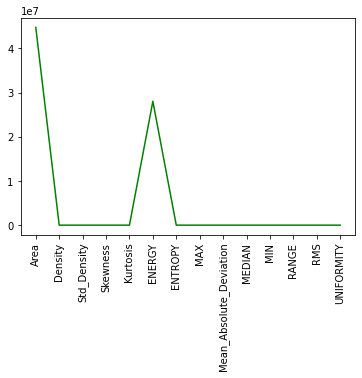

<Figure size 360x360 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.plot(columns_list, sum_normal, color='green')
plt.xticks(rotation=90)
plt.figure(figsize=(5,5))

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 <a list of 14 Text major ticklabel objects>)

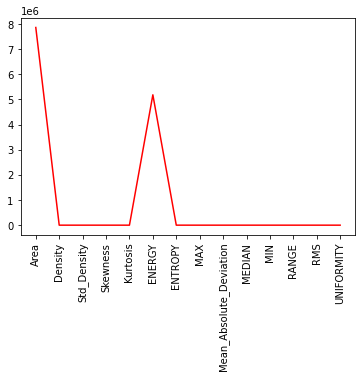

In [ ]:
plt.plot(columns_list,sum_covid, color='red')
plt.xticks(rotation=90)
plt.figure(figsize=(5,5))

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 <a list of 14 Text major ticklabel objects>)

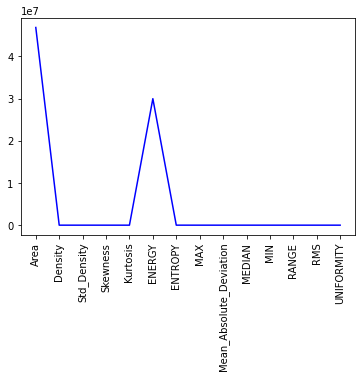

In [ ]:
plt.plot(columns_list,sum_pneumonia, color='blue')
plt.xticks(rotation=90)
plt.figure(figsize=(5,5))

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 <a list of 14 Text major ticklabel objects>)

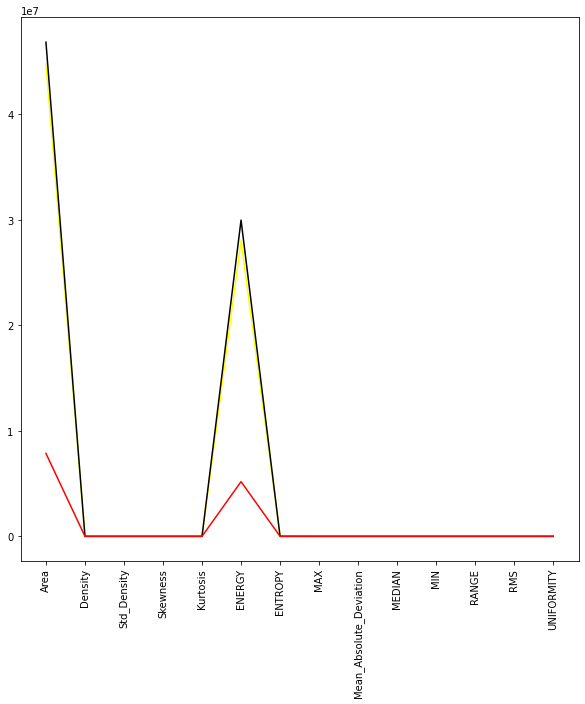

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(columns_list, sum_normal, color='yellow', label="normal")
plt.plot(columns_list,sum_pneumonia, color='black', label="pneumonia")
plt.plot(columns_list,sum_covid, color='red', label="covid")
plt.xticks(rotation=90)

In [ ]:
print(df_covid.Area.min())
print(df_covid.Density.min())
print(df_covid.Std_Density.min())
print(df_covid.Skewness.min())
print(df_covid.Kurtosis.min())
print(df_covid.ENERGY.min())
print(df_covid.ENTROPY.min())
print(df_covid.MAX.min())
print(df_covid.Mean_Absolute_Deviation.min())
print(df_covid.MEDIAN.min())
print(df_covid.MIN.min())
print(df_covid.RANGE.min())
print(df_covid.RMS.min())
print(df_covid.UNIFORMITY.min())

71257.94901960784
0.271830614133645
0.16082438377587902
-1.1183450587712114
-1.5305308644349611
33241.35543252596
5.900170509417621
1.0
0.13040438081100153
0.2823529411764706
0.0039215686274509795
0.992156862745098
0.3560999282039974
0.004531228633592802


In [ ]:
print(df_covid.Area.max())
print(df_covid.Density.max())
print(df_covid.Std_Density.max())
print(df_covid.Skewness.max())
print(df_covid.Kurtosis.max())
print(df_covid.ENERGY.max())
print(df_covid.ENTROPY.max())
print(df_covid.MAX.max())
print(df_covid.Mean_Absolute_Deviation.max())
print(df_covid.MEDIAN.max())
print(df_covid.MIN.max())
print(df_covid.RANGE.max())
print(df_covid.RMS.max())
print(df_covid.UNIFORMITY.max())

182741.5176470588
0.6971594161788887
0.33094627002427834
0.19405847866100226
0.5801877738122347
138788.2496732026
7.8542157575397935
1.0
0.2891932890258239
0.7568627450980392
0.007843137254901959
0.996078431372549
0.7276520956190774
0.06871669917605881


In [ ]:
print(df_covid.Area.mean())
print(df_covid.Density.mean())
print(df_covid.Std_Density.mean())
print(df_covid.Skewness.mean())
print(df_covid.Kurtosis.mean())
print(df_covid.ENERGY.mean())
print(df_covid.ENTROPY.mean())
print(df_covid.MAX.mean())
print(df_covid.Mean_Absolute_Deviation.mean())
print(df_covid.MEDIAN.mean())
print(df_covid.MIN.mean())
print(df_covid.RANGE.mean())
print(df_covid.RMS.mean())
print(df_covid.UNIFORMITY.mean())

142917.39543672014
0.5452885733317656
0.22969917875719154
-0.5104969890914411
-0.5399733453860436
94242.99765460836
7.436445374253091
1.0
0.19298175232304876
0.5874509803921572
0.004064171122994646
0.9959358288770065
0.5946713105882264
0.011632006967670678


In [ ]:
print(df_normal.Area.min())
print(df_normal.Density.min())
print(df_normal.Std_Density.min())
print(df_normal.Skewness.min())
print(df_normal.Kurtosis.min())
print(df_normal.ENERGY.min())
print(df_normal.ENTROPY.min())
print(df_normal.MAX.min())
print(df_normal.Mean_Absolute_Deviation.min())
print(df_normal.MEDIAN.min())
print(df_normal.MIN.min())
print(df_normal.RANGE.min())
print(df_normal.RMS.min())
print(df_normal.UNIFORMITY.min())

101374.56078431373
0.3867176854605488
0.18225415906124387
-0.9260716640049532
-1.3661924667850451
47910.76261437909
6.8783531011804335
1.0
0.14688533391372238
0.35294117647058826
0.0039215686274509795
0.996078431372549
0.4275127445387858
0.004393385304674846


In [ ]:
print(df_normal.Area.max())
print(df_normal.Density.max())
print(df_normal.Std_Density.max())
print(df_normal.Skewness.max())
print(df_normal.Kurtosis.max())
print(df_normal.ENERGY.max())
print(df_normal.ENTROPY.max())
print(df_normal.MAX.max())
print(df_normal.Mean_Absolute_Deviation.max())
print(df_normal.MEDIAN.max())
print(df_normal.MIN.max())
print(df_normal.RANGE.max())
print(df_normal.RMS.max())
print(df_normal.UNIFORMITY.max())

158750.2901960784
0.6056305038686972
0.3013988999306082
0.5474849534604584
-0.07221738472437922
114864.27195693964
7.90131062204705
1.0
0.26487675009573475
0.6745098039215687
0.0039215686274509795
0.996078431372549
0.6620633869718782
0.05271417643803985


In [ ]:
print(df_normal.Area.mean())
print(df_normal.Density.mean())
print(df_normal.Std_Density.mean())
print(df_normal.Skewness.mean())
print(df_normal.Kurtosis.mean())
print(df_normal.ENERGY.mean())
print(df_normal.ENTROPY.mean())
print(df_normal.MAX.mean())
print(df_normal.Mean_Absolute_Deviation.mean())
print(df_normal.MEDIAN.mean())
print(df_normal.MIN.mean())
print(df_normal.RANGE.mean())
print(df_normal.RMS.mean())
print(df_normal.UNIFORMITY.mean())


128207.85003651894
0.4922782760648756
0.25356377750683806
-0.3351764028263072
-0.844195379497131
80343.63030599865
7.563405994847949
1.0
0.2130341095039656
0.524580032586101
0.003921568627450967
0.9960784313725523
0.5546075631359204
0.011422731585608834


In [ ]:
print(df_pneumonia.Area.min())
print(df_pneumonia.Density.min())
print(df_pneumonia.Std_Density.min())
print(df_pneumonia.Skewness.min())
print(df_pneumonia.Kurtosis.min())
print(df_pneumonia.ENERGY.min())
print(df_pneumonia.ENTROPY.min())
print(df_pneumonia.MAX.min())
print(df_pneumonia.Mean_Absolute_Deviation.min())
print(df_pneumonia.MEDIAN.min())
print(df_pneumonia.MIN.min())
print(df_pneumonia.RANGE.min())
print(df_pneumonia.RMS.min())
print(df_pneumonia.UNIFORMITY.min())

89220.12941176469
0.3463433670479907
0.1707264634613305
-1.454850124783868
-1.5337677504172518
43103.53934640524
6.462483248951428
1.0
0.1264542101218208
0.3450980392156863
0.0039215686274509795
0.992156862745098
0.4065121524240747
0.004335162791572545


In [ ]:
print(df_pneumonia.Area.max())
print(df_pneumonia.Density.max())
print(df_pneumonia.Std_Density.max())
print(df_pneumonia.Skewness.max())
print(df_pneumonia.Kurtosis.max())
print(df_pneumonia.ENERGY.max())
print(df_pneumonia.ENTROPY.max())
print(df_pneumonia.MAX.max())
print(df_pneumonia.Mean_Absolute_Deviation.max())
print(df_pneumonia.MEDIAN.max())
print(df_pneumonia.MIN.max())
print(df_pneumonia.RANGE.max())
print(df_pneumonia.RMS.max())
print(df_pneumonia.UNIFORMITY.max())


175209.22745098034
0.6683829092618052
0.3286992484687997
0.3999459532830949
2.1058521143291618
126322.04227604765
7.918064538103782
1.0
0.290437827326658
0.7254901960784313
0.007843137254901959
0.996078431372549
0.6941826420850412
0.07506815886395513


In [ ]:
print(df_pneumonia.Area.mean())
print(df_pneumonia.Density.mean())
print(df_pneumonia.Std_Density.mean())
print(df_pneumonia.Skewness.mean())
print(df_pneumonia.Kurtosis.mean())
print(df_pneumonia.ENERGY.mean())
print(df_pneumonia.ENTROPY.mean())
print(df_pneumonia.MAX.mean())
print(df_pneumonia.Mean_Absolute_Deviation.mean())
print(df_pneumonia.MEDIAN.mean())
print(df_pneumonia.MIN.mean())
print(df_pneumonia.RANGE.mean())
print(df_pneumonia.RMS.mean())
print(df_pneumonia.UNIFORMITY.mean())


133445.57685045525
0.5150428251851737
0.2446536778679191
-0.5212999065961345
-0.724659041103703
85391.92393282878
7.445035189013166
1.0
0.20716843633445406
0.5683369644153959
0.004066811909949152
0.995933188090054
0.5719539493062005
0.012322753938049201
